# Starting example: the unicycle

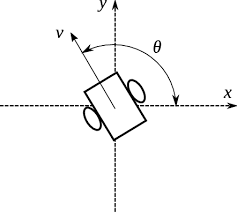

An unicycle represents a kinematic model of a car where it's only possible to move in two directions, i.e. it drives forward and turns on the spot. Its dynamics has nonholonomic constraints because it cannot move sideways. Remember that nonholonomic constraints are nonintegral and has the form $\mathbf{f(q,\dot{q})=0}$.

In this example, we define an optimal-control problem for the classical unicycle problem. Our goal is to drive the unicycle towards the origin but at the same time not too fast. For that, the cost function is described as the sum between the distance to the origin and the system speed.


**Issue on Ubuntu 16.04**

You need to upgrate the matplotlib library, please do:
 - pip install --upgrade --user pip
 - pip install --upgrade --user matplotlib

Basically, our optimal control problem has the following dynamical model and cost function:

In [1]:
import numpy as np
import matplotlib.pylab as plt

x = np.random.rand(3)
u = np.random.rand(2)

# Unicycle dynamical model
v, w = u
c, s = np.cos(x[2]), np.sin(x[2])
dt = 1e-2
dx = np.array([v * c, v * s, w])
xnext = x + dx * dt

# Cost function: driving to origin (state) and reducing speed (control)
stateWeight = 1
ctrlWeight = 1
costResiduals = np.concatenate([stateWeight * x, ctrlWeight * u])
cost = .5 * sum(costResiduals ** 2)

For this basic example, the unicycle model is coded in the library. We will just load it and use it. If you are very curious, have a look! It is in `crocoddyl/unicycle.py`. 

We create such a model with the following lines:

In [2]:
import crocoddyl
model = crocoddyl.ActionModelUnicycle()
data = model.createData()

The action model contains ... well ... the description of the dynamics and cost function. There you find also the action model parameters (here the time step and the cost weights). On the other hand, the data has the buffers where the results of the calculus are stored.

We decided for this separation for an obvious reason that is given just below.

In [3]:
model.costWeights = np.matrix([
    1,   # state weight
    1  # control weight
]).T

**You can further understand the mathematical definition of action models see introduction_to_crocoddyl.ipynb**

## I. Defining the shooting problem
A shooting problem is defined by the initial state from which computing the rollout and a sequence of action models.


In [4]:
x0 = np.matrix([-1., -1., 1.]).T  # x, y, theta
T = 20
problem = crocoddyl.ShootingProblem(x0, [model] * T, model)

Here we define a problem starting from $\mathbf{x}_0$ with 20 timesteps (of 0.1 sec by default implementation of unicycle). The terminal action model is defined using the running action model.

This defines the model, not any algorithm to solve it. The only computation that the problem can provide is to integrate the system for a given sequence of controls.

In [5]:
us = [np.matrix([1., 1.]).T for _ in range(T)]
xs = problem.rollout(us)

The plotUnicycle function plots the system as two arrows that represent the wheels

(-2.0, 2.0, -2.0, 2.0)

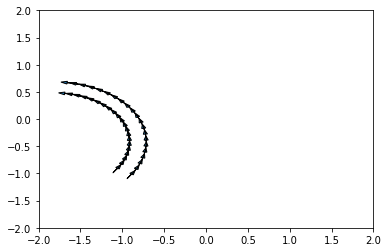

In [6]:
%matplotlib inline
from unicycle_utils import plotUnicycle
for x in xs: 
    plotUnicycle(x)
plt.axis([-2, 2., -2., 2.])

## II. Solve the OCP
The main solver is named SolverDDP. It is initialized from the problem object and mostly contains the ddp.solve method. We can warm start it and tune the parameters, but for the simple unicycle, let's just solve it!

In [ ]:
ddp = crocoddyl.SolverDDP(problem)
done = ddp.solve()
assert done

In [ ]:
plt.clf()
for x in ddp.xs: 
    plotUnicycle(x)
plt.axis([-2, 2, -2, 2])

and the final state is:

In [ ]:
print(ddp.xs[-1])

# Well, the terminal state is not so nicely in the origin.

Question 1: why?

Question 2: How can you change this?

Question 3: by changing the cost parameters, the time horizon and the initial position, can you trigger a maneuver?